# Target Scaling Strategies for Mass Spectrometry Prediction

This notebook explores comprehensive target transformation strategies to improve mass spectrum intensity prediction. We systematically evaluate different scaling methods to handle the wide dynamic range and heteroscedastic nature of mass spectrometry data.

## Transformations Implemented:

### 1. Power Transformations
- **Square Root**: $y_{transformed} = \sqrt{y}$ - Reduces variance for high intensities
- **Logarithmic**: $y_{transformed} = \log(y + 1)$ - Handles wide dynamic range
- **Custom Power**: $y_{transformed} = y^{\alpha}$ - Optimizable power parameter
- **Asinh**: $y_{transformed} = \text{asinh}(y)$ - Log-like but handles zeros naturally

### 2. Statistical Transformations
- **Box-Cox**: Finds optimal power transformation with $\lambda$ parameter
- **Yeo-Johnson**: Extension of Box-Cox that handles zero and negative values
- **Quantile**: Maps to uniform or normal distribution
- **Rank**: Converts intensities to ranks

### 3. Custom Mass Spec Transformations
- **Adaptive Scaling**: Different transformations for different intensity ranges
- **Peak-aware Scaling**: Special handling for peak vs background regions
- **m/z-dependent Scaling**: Different transformations for different m/z ranges

## Evaluation Framework:
- Fixed Random Forest model for consistent comparison
- Primary metric: Cosine similarity (shape preservation)
- Secondary metrics: MSE, peak detection accuracy, dynamic range preservation
- Analysis of transformation effects on different intensity ranges

**Input**: Featurized JSONL data from previous notebooks

**Output**: Optimal transformation strategy with performance metrics and recommendations

## 1. Environment Setup

Import required libraries and configure the environment for transformation analysis.

### Key Components:
- **scikit-learn**: Preprocessing transformations and evaluation
- **SciPy**: Statistical transformations (Box-Cox, Yeo-Johnson)
- **NumPy**: Custom transformations and numerical operations
- **Matplotlib/Seaborn**: Visualization of transformation effects
- **joblib**: Parallel evaluation of transformations

In [15]:
# Standard library imports
import os
import json
import pickle
import time
import warnings
from typing import Dict, List, Tuple, Any, Optional, Callable
from concurrent.futures import ThreadPoolExecutor, as_completed

# Data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Machine learning imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import (
    StandardScaler, QuantileTransformer, 
    PowerTransformer, FunctionTransformer
)
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.spatial.distance import cosine
from scipy import stats
from scipy.special import inv_boxcox, inv_boxcox1p
from scipy.optimize import minimize_scalar

# Configure warnings
warnings.filterwarnings('ignore')

# Publication-style plotting (match 01_eda.ipynb)
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Set random seed
SEED = 42
np.random.seed(SEED)

print("Environment setup complete")
print(f"NumPy version: {np.__version__}")
print(f"Number of CPU cores: {os.cpu_count()}")

Environment setup complete
NumPy version: 1.26.4
Number of CPU cores: 16


## 2. Master Configuration

Central configuration for all transformation methods and evaluation parameters.

### Configuration Structure:

**Transformation Settings:**
- Power transformations with various alpha values
- Statistical transformations with optimized parameters
- Custom transformations for mass spectrometry data

**Evaluation Settings:**
- Fixed RF hyperparameters for fair comparison
- Consistent train/test splits
- Multiple evaluation metrics

**Analysis Settings:**
- Intensity range bins for detailed analysis
- Peak detection thresholds
- Visualization parameters

In [16]:
MASTER_CONFIG = {
    # Paths configuration
    'paths': {
        'results_dir': '../data/results',
        'models_dir': '../models',
        'scaling_results_dir': '../data/results/target_scaling',
        'input_type': 'hpj',
        'data_subdir': 'full_featurised'
    },
    
    # Transformation configurations
    'transformations': {
        'power': {
            'sqrt': 0.5,
            'cbrt': 0.333,
            'fourth_root': 0.25,
            'custom_powers': [0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9]
        },
        'log': {
            'epsilon': 1.0,  # log(y + epsilon)
            'base': 'natural'  # Could be 'natural', '10', '2'
        },
        'quantile': {
            'n_quantiles': 1000,
            'output_distribution': 'normal',  # 'normal' or 'uniform'
            'subsample': 100000  # For efficiency
        },
        'adaptive': {
            'low_threshold': 0.01,    # Below this: log transform
            'high_threshold': 0.5,    # Above this: sqrt transform
            'mid_power': 0.7         # Between: power transform
        }
    },
    
    # Fixed RF evaluation parameters
    'rf_eval': {
        'n_estimators': 100,
        'max_depth': 25,
        'min_samples_split': 3,
        'min_samples_leaf': 1,
        'n_jobs': -1,
        'random_state': 42
    },
    
    # Analysis settings
    'analysis': {
        'intensity_bins': [0, 0.001, 0.01, 0.1, 0.5, 1.0],
        'mz_ranges': {
            'low': (0, 100),
            'mid': (100, 300),
            'high': (300, 500)
        },
        'peak_threshold': 0.01,
        'n_example_spectra': 5
    },
    
    # General settings
    'general': {
        'random_state': 42,
        'n_jobs': max(1, os.cpu_count() - 1),
        'verbose': True
    }
}

# Create directories
os.makedirs(MASTER_CONFIG['paths']['scaling_results_dir'], exist_ok=True)
print(f"Configuration loaded. Results will be saved to: {MASTER_CONFIG['paths']['scaling_results_dir']}")

Configuration loaded. Results will be saved to: ../data/results/target_scaling


## 3. Data Loading and Utility Functions

Core functions for data loading, transformation, and evaluation.

### Key Functions:

**Data Management:**
- `load_jsonl_data`: Loads featurized molecular data
- `get_data_statistics`: Analyzes target distribution

**Transformation Functions:**
- `apply_transformation`: Applies various transformations with proper handling
- `inverse_transformation`: Reverses transformations for evaluation

**Evaluation Metrics:**
- `cosine_similarity_score`: Primary metric for spectral similarity
- `evaluate_transformation`: Comprehensive evaluation suite
- `analyze_intensity_ranges`: Performance by intensity level

In [17]:
# Data I/O utilities (aligned with 01_training.ipynb)

def get_data_paths(config: Dict) -> Dict[str, str]:
    """Build train/val/test JSONL paths using config.
    Supports both a static 'data_subdir' string and the callable form
    used in 01_training.ipynb.
    """
    input_type_dir = os.path.join(
        config['paths']['results_dir'], config['paths']['input_type']
    )
    data_subdir = config['paths'].get('data_subdir', 'full_featurised')
    if callable(data_subdir):
        data_dir = os.path.join(
            input_type_dir,
            data_subdir(config['paths'].get('use_selected_data', False)),
        )
    else:
        data_dir = os.path.join(input_type_dir, data_subdir)
    return {
        'train': os.path.join(data_dir, 'train_data.jsonl'),
        'val': os.path.join(data_dir, 'val_data.jsonl'),
        'test': os.path.join(data_dir, 'test_data.jsonl'),
    }


def load_jsonl_data(filepath: str) -> Tuple[List[str], np.ndarray, np.ndarray]:
    """Load data from a JSONL file (same pattern as 01_training.ipynb)."""
    smiles_list: List[str] = []
    features: List[List[float]] = []
    targets: List[List[float]] = []

    if not os.path.exists(filepath):
        print(f"File not found: {filepath}")
        return smiles_list, np.array(features), np.array(targets)

    # Progress bar over lines
    with open(filepath, 'r') as f:
        total_lines = sum(1 for _ in f)

    with open(filepath, 'r') as f:
        for line in tqdm(f, desc=f"Loading {os.path.basename(filepath)}", total=total_lines, unit="spectra"):
            try:
                record = json.loads(line)
                smiles = record.get('smiles')
                feat = record.get('features')
                targ = record.get('target')
                if smiles and feat is not None and targ is not None:
                    smiles_list.append(smiles)
                    features.append(feat)
                    targets.append(targ)
            except (json.JSONDecodeError, KeyError):
                continue

    print(f"Loaded {len(smiles_list)} samples from {os.path.basename(filepath)}")
    return smiles_list, np.array(features), np.array(targets)


def load_all_data(config: Dict) -> Dict[str, Tuple[List[str], np.ndarray, np.ndarray]]:
    """Parallel loading of train/val/test datasets (optional utility)."""
    paths = get_data_paths(config)
    datasets: Dict[str, Tuple[List[str], np.ndarray, np.ndarray]] = {}

    with ThreadPoolExecutor(max_workers=3) as executor:
        future_to_name = {executor.submit(load_jsonl_data, p): n for n, p in paths.items()}
        for future in as_completed(future_to_name):
            name = future_to_name[future]
            try:
                datasets[name] = future.result()
            except Exception as e:
                print(f"Error loading {name}: {e}")
                datasets[name] = ([], np.array([]), np.array([]))
    return datasets


def get_data_statistics(y: np.ndarray) -> Dict[str, Any]:
    """Compute basic statistics for target matrix y."""
    stats_dict: Dict[str, Any] = {}
    stats_dict['shape'] = y.shape
    if y.size == 0:
        return stats_dict
    y_flat = y.flatten()
    y_nonzero = y_flat[y_flat > 0]
    stats_dict['min'] = float(np.min(y_flat))
    stats_dict['max'] = float(np.max(y_flat))
    stats_dict['mean'] = float(np.mean(y_flat))
    stats_dict['median'] = float(np.median(y_flat))
    stats_dict['std'] = float(np.std(y_flat))
    stats_dict['zeros_percent'] = float((np.sum(y_flat == 0) / len(y_flat)) * 100)
    if len(y_nonzero) > 0:
        stats_dict['dynamic_range'] = float(np.log10((np.max(y_nonzero) + 1e-12) / (np.min(y_nonzero) + 1e-12)))
    else:
        stats_dict['dynamic_range'] = 0.0
    try:
        stats_dict['skewness'] = float(stats.skew(y_flat))
        stats_dict['kurtosis'] = float(stats.kurtosis(y_flat))
    except Exception:
        stats_dict['skewness'] = 0.0
        stats_dict['kurtosis'] = 0.0
    return stats_dict

print("Data I/O utilities loaded (aligned with 01_training.ipynb)")


Data I/O utilities loaded (aligned with 01_training.ipynb)


In [18]:
# Cosine similarity utility (aligned with 01_training approach)

def cosine_similarity_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Compute mean cosine similarity across spectra.
    - If both vectors are zero, similarity is 1
    - If either vector is zero (but not both), similarity is 0
    """
    y_true = np.asarray(y_true, dtype=np.float64)
    y_pred = np.asarray(y_pred, dtype=np.float64)

    if y_true.ndim == 1:
        norm_t = np.linalg.norm(y_true)
        norm_p = np.linalg.norm(y_pred)
        if norm_t == 0 and norm_p == 0:
            return 1.0
        if norm_t == 0 or norm_p == 0:
            return 0.0
        return float(np.dot(y_true, y_pred) / (norm_t * norm_p))

    # Row-wise for 2D
    norm_t = np.linalg.norm(y_true, axis=1)
    norm_p = np.linalg.norm(y_pred, axis=1)
    dot = np.sum(y_true * y_pred, axis=1)

    sim = np.zeros_like(dot, dtype=np.float64)
    both_zero = (norm_t == 0) & (norm_p == 0)
    valid = (norm_t > 0) & (norm_p > 0)

    sim[both_zero] = 1.0
    sim[valid] = dot[valid] / (norm_t[valid] * norm_p[valid])

    return float(np.nanmean(sim))

print("Cosine utility loaded")


Cosine utility loaded


In [19]:
def apply_transformation(y, method, params=None):
    """Apply specified transformation to targets."""
    y = np.array(y, dtype=np.float64)
    
    if method == 'none':
        return y, None
    
    elif method == 'sqrt':
        return np.sqrt(y), None
    
    elif method == 'log':
        epsilon = params.get('epsilon', 1.0) if params else 1.0
        return np.log(y + epsilon), {'epsilon': epsilon}
    
    elif method == 'log10':
        epsilon = params.get('epsilon', 1.0) if params else 1.0
        return np.log10(y + epsilon), {'epsilon': epsilon}
    
    elif method == 'asinh':
        return np.arcsinh(y), None
    
    elif method == 'power':
        alpha = params.get('alpha', 0.5) if params else 0.5
        return np.power(y + 1e-10, alpha), {'alpha': alpha}
    
    elif method == 'boxcox':
        # Box-Cox requires positive values
        y_positive = y + np.abs(np.min(y)) + 1e-10
        transformed = np.zeros_like(y)
        lambdas = []
        
        # Apply per spectrum (row)
        for i in range(y.shape[0]):
            try:
                trans, lmbda = stats.boxcox(y_positive[i])
                transformed[i] = trans
                lambdas.append(lmbda)
            except:
                transformed[i] = np.log(y_positive[i])  # Fallback
                lambdas.append(0)
        
        return transformed, {'lambdas': lambdas, 'shift': np.abs(np.min(y)) + 1e-10}
    
    elif method == 'yeo-johnson':
        # Apply Yeo-Johnson per m/z bin
        transformers = []
        transformed = np.zeros_like(y)
        
        for j in range(y.shape[1]):  # For each m/z bin
            transformer = PowerTransformer(method='yeo-johnson', standardize=False)
            # Fit on this m/z bin's data across all samples
            bin_data = y[:, j].reshape(-1, 1)
            transformed[:, j] = transformer.fit_transform(bin_data).flatten()
            transformers.append(transformer)
        
        return transformed, {'transformers': transformers}
    
    elif method == 'quantile_normal':
        # Apply per m/z bin
        transformers = []
        transformed = np.zeros_like(y)
        
        for j in range(y.shape[1]):  # For each m/z bin
            transformer = QuantileTransformer(
                n_quantiles=min(params.get('n_quantiles', 1000) if params else 1000, len(y)),
                output_distribution='normal',
                subsample=params.get('subsample', 100000) if params else 100000
            )
            bin_data = y[:, j].reshape(-1, 1)
            transformed[:, j] = transformer.fit_transform(bin_data).flatten()
            transformers.append(transformer)
            
        return transformed, {'transformers': transformers}
    
    elif method == 'quantile_uniform':
        # Apply per m/z bin
        transformers = []
        transformed = np.zeros_like(y)
        
        for j in range(y.shape[1]):  # For each m/z bin
            transformer = QuantileTransformer(
                n_quantiles=min(params.get('n_quantiles', 1000) if params else 1000, len(y)),
                output_distribution='uniform',
                subsample=params.get('subsample', 100000) if params else 100000
            )
            bin_data = y[:, j].reshape(-1, 1)
            transformed[:, j] = transformer.fit_transform(bin_data).flatten()
            transformers.append(transformer)
            
        return transformed, {'transformers': transformers}
    
    elif method == 'rank':
        # Rank transformation per spectrum
        transformed = np.zeros_like(y)
        for i in range(y.shape[0]):
            transformed[i] = stats.rankdata(y[i]) / len(y[i])
        return transformed, None
    
    elif method == 'adaptive':
        # Adaptive transformation based on intensity
        low_thresh = params.get('low_threshold', 0.01) if params else 0.01
        high_thresh = params.get('high_threshold', 0.5) if params else 0.5
        mid_power = params.get('mid_power', 0.7) if params else 0.7
        
        transformed = np.zeros_like(y)
        
        # Low intensity: log transform
        low_mask = y <= low_thresh
        transformed[low_mask] = np.log(y[low_mask] + 1e-10)
        
        # High intensity: sqrt transform
        high_mask = y >= high_thresh
        transformed[high_mask] = np.sqrt(y[high_mask])
        
        # Mid intensity: power transform
        mid_mask = (y > low_thresh) & (y < high_thresh)
        transformed[mid_mask] = np.power(y[mid_mask], mid_power)
        
        return transformed, {'low_threshold': low_thresh, 
                           'high_threshold': high_thresh,
                           'mid_power': mid_power}
    
    else:
        raise ValueError(f"Unknown transformation method: {method}")

def inverse_transformation(y_transformed, method, transform_params):
    """Apply inverse transformation for evaluation."""
    if method == 'none':
        return y_transformed
    
    elif method == 'sqrt':
        return np.square(y_transformed)
    
    elif method == 'log':
        epsilon = transform_params.get('epsilon', 1.0) if transform_params else 1.0
        return np.exp(y_transformed) - epsilon
    
    elif method == 'log10':
        epsilon = transform_params.get('epsilon', 1.0) if transform_params else 1.0
        return np.power(10, y_transformed) - epsilon
    
    elif method == 'asinh':
        return np.sinh(y_transformed)
    
    elif method == 'power':
        alpha = transform_params.get('alpha', 0.5) if transform_params else 0.5
        return np.power(np.maximum(y_transformed, 0), 1/alpha) - 1e-10
    
    elif method in ['quantile_normal', 'quantile_uniform', 'yeo-johnson']:
        transformers = transform_params.get('transformers')
        if transformers:
            inversed = np.zeros_like(y_transformed)
            for j, transformer in enumerate(transformers):
                bin_data = y_transformed[:, j].reshape(-1, 1)
                inversed[:, j] = transformer.inverse_transform(bin_data).flatten()
            return inversed
        return y_transformed
    
    elif method == 'boxcox':
        # Complex inverse - simplified
        return np.exp(y_transformed) - 1
    
    else:
        # For complex transformations, return as-is
        return y_transformed

def evaluate_transformation(X_train, y_train, X_test, y_test, 
                          transform_method, transform_params=None):
    """Evaluate a transformation method using fixed RF model."""
    start_time = time.time()
    
    # Apply transformation
    y_train_transformed, train_params = apply_transformation(y_train, transform_method, transform_params)
    y_test_transformed, _ = apply_transformation(y_test, transform_method, transform_params)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train RF model
    rf_model = RandomForestRegressor(**MASTER_CONFIG['rf_eval'])
    rf_model.fit(X_train_scaled, y_train_transformed)
    
    # Predict on transformed scale
    y_pred_transformed = rf_model.predict(X_test_scaled)
    
    # Evaluate on TRANSFORMED scale (not inverse transforming)
    y_pred = np.maximum(y_pred_transformed, 0)  # Ensure non-negative
    
    # Calculate metrics on TRANSFORMED scale
    cosine_sim = cosine_similarity_score(y_test_transformed, y_pred)
    mse = mean_squared_error(y_test_transformed, y_pred)
    mae = mean_absolute_error(y_test_transformed, y_pred)
    
    # Peak detection on transformed scale
    threshold_transformed = 0.1  # Adjusted threshold for transformed scale
    true_peaks = y_test_transformed > threshold_transformed
    pred_peaks = y_pred > threshold_transformed
    peak_precision = np.sum(true_peaks & pred_peaks) / np.sum(pred_peaks) if np.sum(pred_peaks) > 0 else 0
    peak_recall = np.sum(true_peaks & pred_peaks) / np.sum(true_peaks) if np.sum(true_peaks) > 0 else 0
    peak_f1 = 2 * (peak_precision * peak_recall) / (peak_precision + peak_recall) if (peak_precision + peak_recall) > 0 else 0
    
    # Also calculate metrics on original scale for reference
    y_pred_original = inverse_transformation(y_pred, transform_method, train_params)
    y_pred_original = np.maximum(y_pred_original, 0)
    cosine_sim_original = cosine_similarity_score(y_test, y_pred_original)
    
    training_time = time.time() - start_time
    
    results = {
        'method': transform_method,
        'params': transform_params,
        'cosine_similarity': cosine_sim,  # On transformed scale
        'cosine_similarity_original': cosine_sim_original,  # On original scale
        'mse': mse,
        'mae': mae,
        'peak_f1': peak_f1,
        'peak_precision': peak_precision,
        'peak_recall': peak_recall,
        'training_time': training_time,
        'y_pred': y_pred,  # Predictions on transformed scale
        'y_test': y_test_transformed,  # Test data on transformed scale
        'y_pred_original': y_pred_original,  # For visualization
        'y_test_original': y_test  # Original test data
    }
    
    return results

def analyze_intensity_ranges(y_true, y_pred, intensity_bins):
    """Analyze performance across different intensity ranges."""
    range_metrics = {}
    
    for i in range(len(intensity_bins) - 1):
        low, high = intensity_bins[i], intensity_bins[i + 1]
        
        # Create mask for this intensity range
        mask = (y_true >= low) & (y_true < high)
        
        if np.sum(mask) > 0:
            y_true_range = y_true[mask]
            y_pred_range = y_pred[mask]
            
            # Calculate metrics for this range
            mse = mean_squared_error(y_true_range, y_pred_range)
            mae = mean_absolute_error(y_true_range, y_pred_range)
            rel_error = np.mean(np.abs(y_true_range - y_pred_range) / (y_true_range + 1e-10))
            
            range_metrics[f"{low:.3f}-{high:.3f}"] = {
                'mse': mse,
                'mae': mae,
                'relative_error': rel_error,
                'n_points': np.sum(mask)
            }
    
    return range_metrics

print("Utility functions loaded")

Utility functions loaded


## 4. Load and Analyze Data

Load the mass spectrometry data and analyze target distribution characteristics.

### Analysis includes:
1. Basic statistics (mean, median, range)
2. Distribution shape (skewness, kurtosis)
3. Dynamic range assessment
4. Zero-value prevalence
5. Intensity distribution visualization

LOADING AND ANALYZING DATA

Loading datasets...


Loading train_data.jsonl: 100%|██████████| 2176/2176 [00:01<00:00, 2108.10spectra/s]


Loaded 2176 samples from train_data.jsonl


Loading val_data.jsonl: 100%|██████████| 272/272 [00:00<00:00, 2382.29spectra/s]


Loaded 272 samples from val_data.jsonl


Loading test_data.jsonl: 100%|██████████| 272/272 [00:00<00:00, 2375.74spectra/s]


Loaded 272 samples from test_data.jsonl

Data shapes:
  Train: X=(2176, 7137), y=(2176, 500)
  Val: X=(272, 7137), y=(272, 500)
  Test: X=(272, 7137), y=(272, 500)

Target Distribution Analysis:
----------------------------------------
  shape: (2176, 500)
  min: 0.000000
  max: 1.000000
  mean: 0.011435
  median: 0.000000
  std: 0.064940
  zeros_percent: 74.515901
  dynamic_range: 2.999957
  skewness: 11.256623
  kurtosis: 148.618919


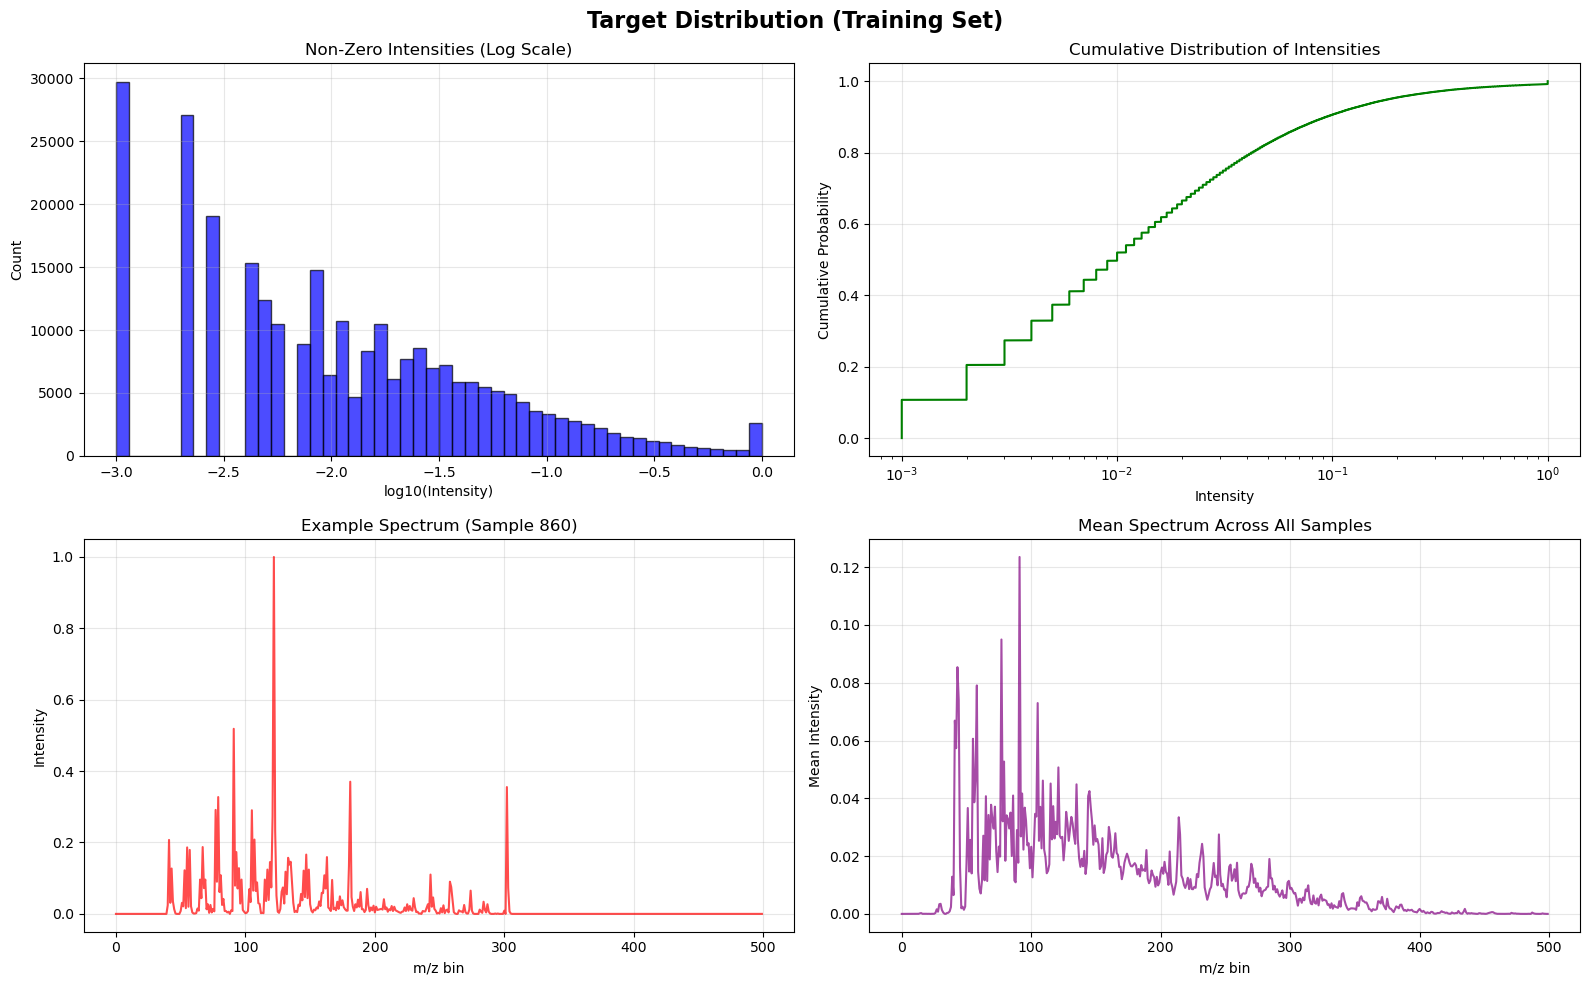


Data analysis complete


In [20]:
print("LOADING AND ANALYZING DATA")
print("=" * 60)

# Define data paths
data_dir = os.path.join(
    MASTER_CONFIG['paths']['results_dir'],
    MASTER_CONFIG['paths']['input_type'],
    MASTER_CONFIG['paths']['data_subdir']
)

# Load datasets
print("\nLoading datasets...")
train_smiles, X_train, y_train = load_jsonl_data(os.path.join(data_dir, 'train_data.jsonl'))
val_smiles, X_val, y_val = load_jsonl_data(os.path.join(data_dir, 'val_data.jsonl'))
test_smiles, X_test, y_test = load_jsonl_data(os.path.join(data_dir, 'test_data.jsonl'))

print(f"\nData shapes:")
print(f"  Train: X={X_train.shape}, y={y_train.shape}")
print(f"  Val: X={X_val.shape}, y={y_val.shape}")
print(f"  Test: X={X_test.shape}, y={y_test.shape}")

# Analyze target distribution
print("\nTarget Distribution Analysis:")
print("-" * 40)

train_stats = get_data_statistics(y_train)
for key, value in train_stats.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.6f}")
    else:
        print(f"  {key}: {value}")

# Visualize target distribution (publication style)
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Target Distribution (Training Set)', fontsize=16, fontweight='bold')

# 1. Histogram of all intensities (log scale)
y_flat = y_train.flatten()
y_nonzero = y_flat[y_flat > 0]

axes[0, 0].hist(np.log10(y_nonzero + 1e-10), bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0, 0].set_xlabel('log10(Intensity)')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Non-Zero Intensities (Log Scale)')
axes[0, 0].grid(True, alpha=0.3)

# 2. Cumulative distribution
sorted_intensities = np.sort(y_nonzero)
cumulative = np.arange(1, len(sorted_intensities) + 1) / len(sorted_intensities)

axes[0, 1].plot(sorted_intensities, cumulative, color='green')
axes[0, 1].set_xscale('log')
axes[0, 1].set_xlabel('Intensity')
axes[0, 1].set_ylabel('Cumulative Probability')
axes[0, 1].set_title('Cumulative Distribution of Intensities')
axes[0, 1].grid(True, alpha=0.3)

# 3. Example spectrum
example_idx = np.random.choice(len(y_train))
axes[1, 0].plot(y_train[example_idx], color='red', alpha=0.7)
axes[1, 0].set_xlabel('m/z bin')
axes[1, 0].set_ylabel('Intensity')
axes[1, 0].set_title(f'Example Spectrum (Sample {example_idx})')
axes[1, 0].grid(True, alpha=0.3)

# 4. Intensity by m/z position
mean_spectrum = np.mean(y_train, axis=0)
axes[1, 1].plot(mean_spectrum, color='purple', alpha=0.7)
axes[1, 1].set_xlabel('m/z bin')
axes[1, 1].set_ylabel('Mean Intensity')
axes[1, 1].set_title('Mean Spectrum Across All Samples')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(MASTER_CONFIG['paths']['scaling_results_dir'], 'target_distribution_analysis.png'), dpi=300)
plt.show()

print("\nData analysis complete")

## 5. Evaluate Standard Transformations

Test common transformation methods used in mass spectrometry and general regression.

### 5.1 Power Transformations

Power transformations reduce heteroscedasticity:

$$y_{transformed} = y^{\alpha}$$

Common values:
- $\alpha = 0.5$: Square root (reduces variance for large values)
- $\alpha = 0.333$: Cube root
- $\alpha \rightarrow 0$: Approaches log transformation

### 5.2 Logarithmic Transformations

Handle wide dynamic range:

$$y_{transformed} = \log(y + \epsilon)$$

Where $\epsilon$ prevents log(0) issues.

In [21]:
print("EVALUATING STANDARD TRANSFORMATIONS")
print("=" * 60)

standard_results = {}

# 5.1 Baseline - No transformation
print("\n5.1 Baseline (No Transformation)")
print("-" * 40)
baseline_result = evaluate_transformation(X_train, y_train, X_test, y_test, 'none')
standard_results['none'] = baseline_result
print(f"  Cosine Similarity: {baseline_result['cosine_similarity']:.6f}")
print(f"  MSE: {baseline_result['mse']:.6f}")
print(f"  Peak F1: {baseline_result['peak_f1']:.4f}")

# 5.2 Power Transformations
print("\n5.2 Power Transformations")
print("-" * 40)

# Standard powers
power_values = {
    'sqrt': 0.5,
    'cbrt': 0.333,
    'fourth_root': 0.25
}

for name, alpha in power_values.items():
    if name == 'sqrt':
        result = evaluate_transformation(X_train, y_train, X_test, y_test, 'sqrt')
    else:
        result = evaluate_transformation(X_train, y_train, X_test, y_test, 'power', {'alpha': alpha})
    
    standard_results[f'power_{name}'] = result
    print(f"  {name} (α={alpha:.3f}): Cosine={result['cosine_similarity']:.6f}, Peak F1={result['peak_f1']:.4f}")

# 5.3 Logarithmic Transformations
print("\n5.3 Logarithmic Transformations")
print("-" * 40)

# Different epsilon values
for epsilon in [0.001, 0.01, 0.1, 1.0]:
    result = evaluate_transformation(X_train, y_train, X_test, y_test, 'log', {'epsilon': epsilon})
    standard_results[f'log_eps_{epsilon}'] = result
    print(f"  log(y + {epsilon}): Cosine={result['cosine_similarity']:.6f}, Peak F1={result['peak_f1']:.4f}")

# Also test log10
result = evaluate_transformation(X_train, y_train, X_test, y_test, 'log10', {'epsilon': 1.0})
standard_results['log10'] = result
print(f"  log10(y + 1): Cosine={result['cosine_similarity']:.6f}, Peak F1={result['peak_f1']:.4f}")

# 5.4 Asinh Transformation
print("\n5.4 Asinh Transformation")
print("-" * 40)
result = evaluate_transformation(X_train, y_train, X_test, y_test, 'asinh')
standard_results['asinh'] = result
print(f"  asinh(y): Cosine={result['cosine_similarity']:.6f}, Peak F1={result['peak_f1']:.4f}")

print("\nStandard transformations complete")

EVALUATING STANDARD TRANSFORMATIONS

5.1 Baseline (No Transformation)
----------------------------------------
  Cosine Similarity: 0.610162
  MSE: 0.002669
  Peak F1: 0.4941

5.2 Power Transformations
----------------------------------------
  sqrt (α=0.500): Cosine=0.779677, Peak F1=0.7179
  cbrt (α=0.333): Cosine=0.837685, Peak F1=0.8019
  fourth_root (α=0.250): Cosine=0.858771, Peak F1=0.8167

5.3 Logarithmic Transformations
----------------------------------------
  log(y + 0.001): Cosine=0.000000, Peak F1=0.0000
  log(y + 0.01): Cosine=0.000000, Peak F1=0.0000
  log(y + 0.1): Cosine=0.000034, Peak F1=0.0000
  log(y + 1.0): Cosine=0.632494, Peak F1=0.4931
  log10(y + 1): Cosine=0.634783, Peak F1=0.4141

5.4 Asinh Transformation
----------------------------------------
  asinh(y): Cosine=0.615804, Peak F1=0.4964

Standard transformations complete


## 6. Optimize Power Transformation

Find the optimal power parameter $\alpha$ that maximizes cosine similarity.

### Optimization Approach:

We use grid search over $\alpha \in [0.1, 0.9]$ to find:

$$\alpha^* = \arg\max_{\alpha} \text{CosineSimilarity}(y_{true}, \hat{y}_{\alpha})$$

Where $\hat{y}_{\alpha}$ are predictions from a model trained on $y^{\alpha}$ transformed targets.

OPTIMIZING POWER TRANSFORMATION

Testing power values...


Power optimization: 100%|██████████| 8/8 [07:11<00:00, 53.92s/it]



Optimal power transformation:
  Alpha: 0.100
  Cosine Similarity: 0.917806


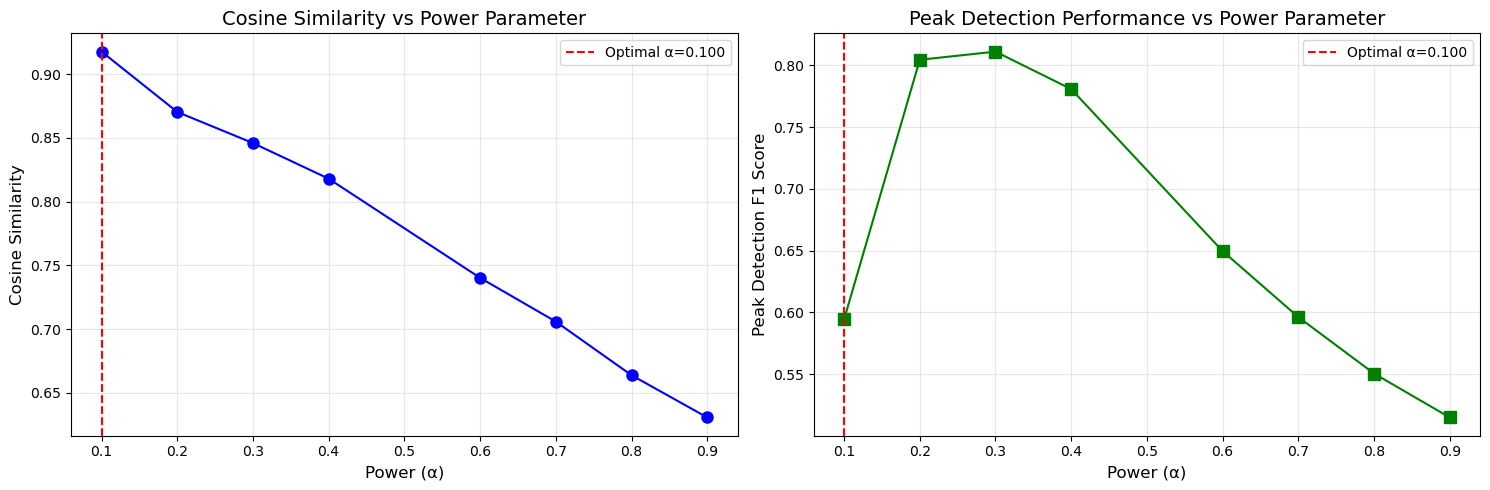

In [22]:
print("OPTIMIZING POWER TRANSFORMATION")
print("=" * 60)

# Grid search over alpha values
alpha_values = MASTER_CONFIG['transformations']['power']['custom_powers']
power_opt_results = []

print("\nTesting power values...")
for alpha in tqdm(alpha_values, desc="Power optimization"):
    result = evaluate_transformation(X_train, y_train, X_test, y_test, 'power', {'alpha': alpha})
    power_opt_results.append({
        'alpha': alpha,
        'cosine_similarity': result['cosine_similarity'],
        'mse': result['mse'],
        'peak_f1': result['peak_f1']
    })

# Convert to DataFrame for analysis
power_df = pd.DataFrame(power_opt_results)

# Find optimal alpha
optimal_idx = power_df['cosine_similarity'].idxmax()
optimal_alpha = power_df.loc[optimal_idx, 'alpha']
optimal_cosine = power_df.loc[optimal_idx, 'cosine_similarity']

print(f"\nOptimal power transformation:")
print(f"  Alpha: {optimal_alpha:.3f}")
print(f"  Cosine Similarity: {optimal_cosine:.6f}")

# Visualize optimization results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Cosine similarity vs alpha
ax1.plot(power_df['alpha'], power_df['cosine_similarity'], 'b-o', markersize=8)
ax1.axvline(optimal_alpha, color='red', linestyle='--', label=f'Optimal α={optimal_alpha:.3f}')
ax1.set_xlabel('Power (α)', fontsize=12)
ax1.set_ylabel('Cosine Similarity', fontsize=12)
ax1.set_title('Cosine Similarity vs Power Parameter', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Peak F1 vs alpha
ax2.plot(power_df['alpha'], power_df['peak_f1'], 'g-s', markersize=8)
ax2.axvline(optimal_alpha, color='red', linestyle='--', label=f'Optimal α={optimal_alpha:.3f}')
ax2.set_xlabel('Power (α)', fontsize=12)
ax2.set_ylabel('Peak Detection F1 Score', fontsize=12)
ax2.set_title('Peak Detection Performance vs Power Parameter', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(MASTER_CONFIG['paths']['scaling_results_dir'], 'power_optimization.png'), dpi=300)
plt.show()

# Store optimal result
optimal_result = evaluate_transformation(X_train, y_train, X_test, y_test, 'power', {'alpha': optimal_alpha})
standard_results[f'power_optimal_{optimal_alpha:.3f}'] = optimal_result

## 7. Statistical Transformations

Evaluate advanced statistical transformations that adapt to data distribution.

### 7.1 Box-Cox Transformation

Finds optimal $\lambda$ parameter:

$$y^{(\lambda)} = \begin{cases}
\frac{y^\lambda - 1}{\lambda} & \text{if } \lambda \neq 0 \\
\ln(y) & \text{if } \lambda = 0
\end{cases}$$

### 7.2 Yeo-Johnson Transformation

Extension of Box-Cox that handles zero and negative values.

### 7.3 Quantile Transformation

Maps empirical distribution to:
- Uniform distribution: Equal probability across range
- Normal distribution: Gaussian-like distribution

In [23]:
print("EVALUATING STATISTICAL TRANSFORMATIONS")
print("=" * 60)

statistical_results = {}

# 7.1 Box-Cox Transformation
print("\n7.1 Box-Cox Transformation")
print("-" * 40)
print("  Note: Box-Cox requires positive values, applying shift...")

result = evaluate_transformation(X_train, y_train, X_test, y_test, 'boxcox')
statistical_results['boxcox'] = result
print(f"  Box-Cox: Cosine={result['cosine_similarity']:.6f}, Peak F1={result['peak_f1']:.4f}")

# 7.2 Yeo-Johnson Transformation
print("\n7.2 Yeo-Johnson Transformation")
print("-" * 40)

result = evaluate_transformation(X_train, y_train, X_test, y_test, 'yeo-johnson')
statistical_results['yeo-johnson'] = result
print(f"  Yeo-Johnson: Cosine={result['cosine_similarity']:.6f}, Peak F1={result['peak_f1']:.4f}")

# 7.3 Quantile Transformations
print("\n7.3 Quantile Transformations")
print("-" * 40)

# Normal distribution
result = evaluate_transformation(
    X_train, y_train, X_test, y_test, 
    'quantile_normal', 
    {'n_quantiles': MASTER_CONFIG['transformations']['quantile']['n_quantiles']}
)
statistical_results['quantile_normal'] = result
print(f"  Quantile (Normal): Cosine={result['cosine_similarity']:.6f}, Peak F1={result['peak_f1']:.4f}")

# Uniform distribution
result = evaluate_transformation(
    X_train, y_train, X_test, y_test, 
    'quantile_uniform',
    {'n_quantiles': MASTER_CONFIG['transformations']['quantile']['n_quantiles']}
)
statistical_results['quantile_uniform'] = result
print(f"  Quantile (Uniform): Cosine={result['cosine_similarity']:.6f}, Peak F1={result['peak_f1']:.4f}")

# 7.4 Rank Transformation
print("\n7.4 Rank Transformation")
print("-" * 40)

result = evaluate_transformation(X_train, y_train, X_test, y_test, 'rank')
statistical_results['rank'] = result
print(f"  Rank: Cosine={result['cosine_similarity']:.6f}, Peak F1={result['peak_f1']:.4f}")

print("\nStatistical transformations complete")

EVALUATING STATISTICAL TRANSFORMATIONS

7.1 Box-Cox Transformation
----------------------------------------
  Note: Box-Cox requires positive values, applying shift...
  Box-Cox: Cosine=0.000000, Peak F1=0.0000

7.2 Yeo-Johnson Transformation
----------------------------------------
  Yeo-Johnson: Cosine=0.857763, Peak F1=0.5918

7.3 Quantile Transformations
----------------------------------------
  Quantile (Normal): Cosine=0.060813, Peak F1=0.5373
  Quantile (Uniform): Cosine=0.826777, Peak F1=0.7563

7.4 Rank Transformation
----------------------------------------
  Rank: Cosine=0.975266, Peak F1=1.0000

Statistical transformations complete


## 8. Custom Mass Spectrometry Transformations

Develop transformations specifically designed for mass spectrometry characteristics.

### 8.1 Adaptive Transformation

Different transformations for different intensity ranges:
- **Low intensity** (< 0.01): Log transformation to expand scale
- **Medium intensity** (0.01-0.5): Power transformation
- **High intensity** (> 0.5): Square root to compress scale

### 8.2 m/z-Dependent Transformation

Apply different transformations based on m/z position to account for:
- Higher noise at low m/z
- Different dynamic ranges across spectrum
- Peak characteristics varying with mass

In [24]:
print("CUSTOM MASS SPECTROMETRY TRANSFORMATIONS")
print("=" * 60)

custom_results = {}

# 8.1 Adaptive Transformation
print("\n8.1 Adaptive Intensity-Based Transformation")
print("-" * 40)

# Test different threshold configurations
adaptive_configs = [
    {'low_threshold': 0.01, 'high_threshold': 0.5, 'mid_power': 0.7},
    {'low_threshold': 0.005, 'high_threshold': 0.3, 'mid_power': 0.6},
    {'low_threshold': 0.02, 'high_threshold': 0.7, 'mid_power': 0.8}
]

best_adaptive_cosine = -1
best_adaptive_config = None

for config in adaptive_configs:
    result = evaluate_transformation(X_train, y_train, X_test, y_test, 'adaptive', config)
    print(f"  Config {config}: Cosine={result['cosine_similarity']:.6f}")
    
    if result['cosine_similarity'] > best_adaptive_cosine:
        best_adaptive_cosine = result['cosine_similarity']
        best_adaptive_config = config
        custom_results['adaptive_best'] = result

print(f"\nBest adaptive configuration: {best_adaptive_config}")

# 8.2 m/z-Dependent Transformation
print("\n8.2 m/z-Dependent Transformation")
print("-" * 40)

def mz_dependent_transform(y_train, y_test):
    """Apply different transformations based on m/z position."""
    n_bins = y_train.shape[1]
    
    # Define m/z ranges and their transformations
    low_mz = int(n_bins * 0.2)   # First 20%
    mid_mz = int(n_bins * 0.6)   # 20-60%
    # Remaining is high m/z
    
    y_train_transformed = np.zeros_like(y_train)
    y_test_transformed = np.zeros_like(y_test)
    
    # Low m/z: log transform (more noise)
    y_train_transformed[:, :low_mz] = np.log(y_train[:, :low_mz] + 0.01)
    y_test_transformed[:, :low_mz] = np.log(y_test[:, :low_mz] + 0.01)
    
    # Mid m/z: power transform
    y_train_transformed[:, low_mz:mid_mz] = np.power(y_train[:, low_mz:mid_mz], 0.6)
    y_test_transformed[:, low_mz:mid_mz] = np.power(y_test[:, low_mz:mid_mz], 0.6)
    
    # High m/z: sqrt transform
    y_train_transformed[:, mid_mz:] = np.sqrt(y_train[:, mid_mz:])
    y_test_transformed[:, mid_mz:] = np.sqrt(y_test[:, mid_mz:])
    
    return y_train_transformed, y_test_transformed

# Apply m/z-dependent transformation
y_train_mz, y_test_mz = mz_dependent_transform(y_train, y_test)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train and evaluate
rf_model = RandomForestRegressor(**MASTER_CONFIG['rf_eval'])
rf_model.fit(X_train_scaled, y_train_mz)
y_pred_mz = rf_model.predict(X_test_scaled)

# Simple inverse (approximate)
y_pred = np.maximum(y_pred_mz, 0)

# Calculate metrics
cosine_sim = cosine_similarity_score(y_test, y_pred)
custom_results['mz_dependent'] = {
    'method': 'mz_dependent',
    'cosine_similarity': cosine_sim,
    'y_pred': y_pred,
    'y_test': y_test
}

print(f"  m/z-dependent: Cosine={cosine_sim:.6f}")

print("\nCustom transformations complete")

CUSTOM MASS SPECTROMETRY TRANSFORMATIONS

8.1 Adaptive Intensity-Based Transformation
----------------------------------------
  Config {'low_threshold': 0.01, 'high_threshold': 0.5, 'mid_power': 0.7}: Cosine=0.000659
  Config {'low_threshold': 0.005, 'high_threshold': 0.3, 'mid_power': 0.6}: Cosine=0.000769
  Config {'low_threshold': 0.02, 'high_threshold': 0.7, 'mid_power': 0.8}: Cosine=0.000591

Best adaptive configuration: {'low_threshold': 0.005, 'high_threshold': 0.3, 'mid_power': 0.6}

8.2 m/z-Dependent Transformation
----------------------------------------
  m/z-dependent: Cosine=0.374698

Custom transformations complete


## 9. Comprehensive Results Analysis

Analyze and compare all transformation methods across multiple dimensions.

### Analysis Components:
1. Overall performance ranking
2. Performance by intensity range
3. Transformation effect visualization
4. Computational efficiency comparison

COMPREHENSIVE RESULTS ANALYSIS

Top 10 Transformation Methods:
------------------------------------------------------------
Rank   Method                         Cosine Sim   Peak F1    Category    
------------------------------------------------------------
16     rank                           0.975266     1.0000     Statistical 
11     power_optimal_0.100            0.917806     0.5942     Standard    
4      power_fourth_root              0.858771     0.8167     Standard    
13     yeo-johnson                    0.857763     0.5918     Statistical 
3      power_cbrt                     0.837685     0.8019     Standard    
15     quantile_uniform               0.826777     0.7563     Statistical 
2      power_sqrt                     0.779677     0.7179     Standard    
9      log10                          0.634783     0.4141     Standard    
8      log_eps_1.0                    0.632494     0.4931     Standard    
10     asinh                          0.615804     0.4964     Sta

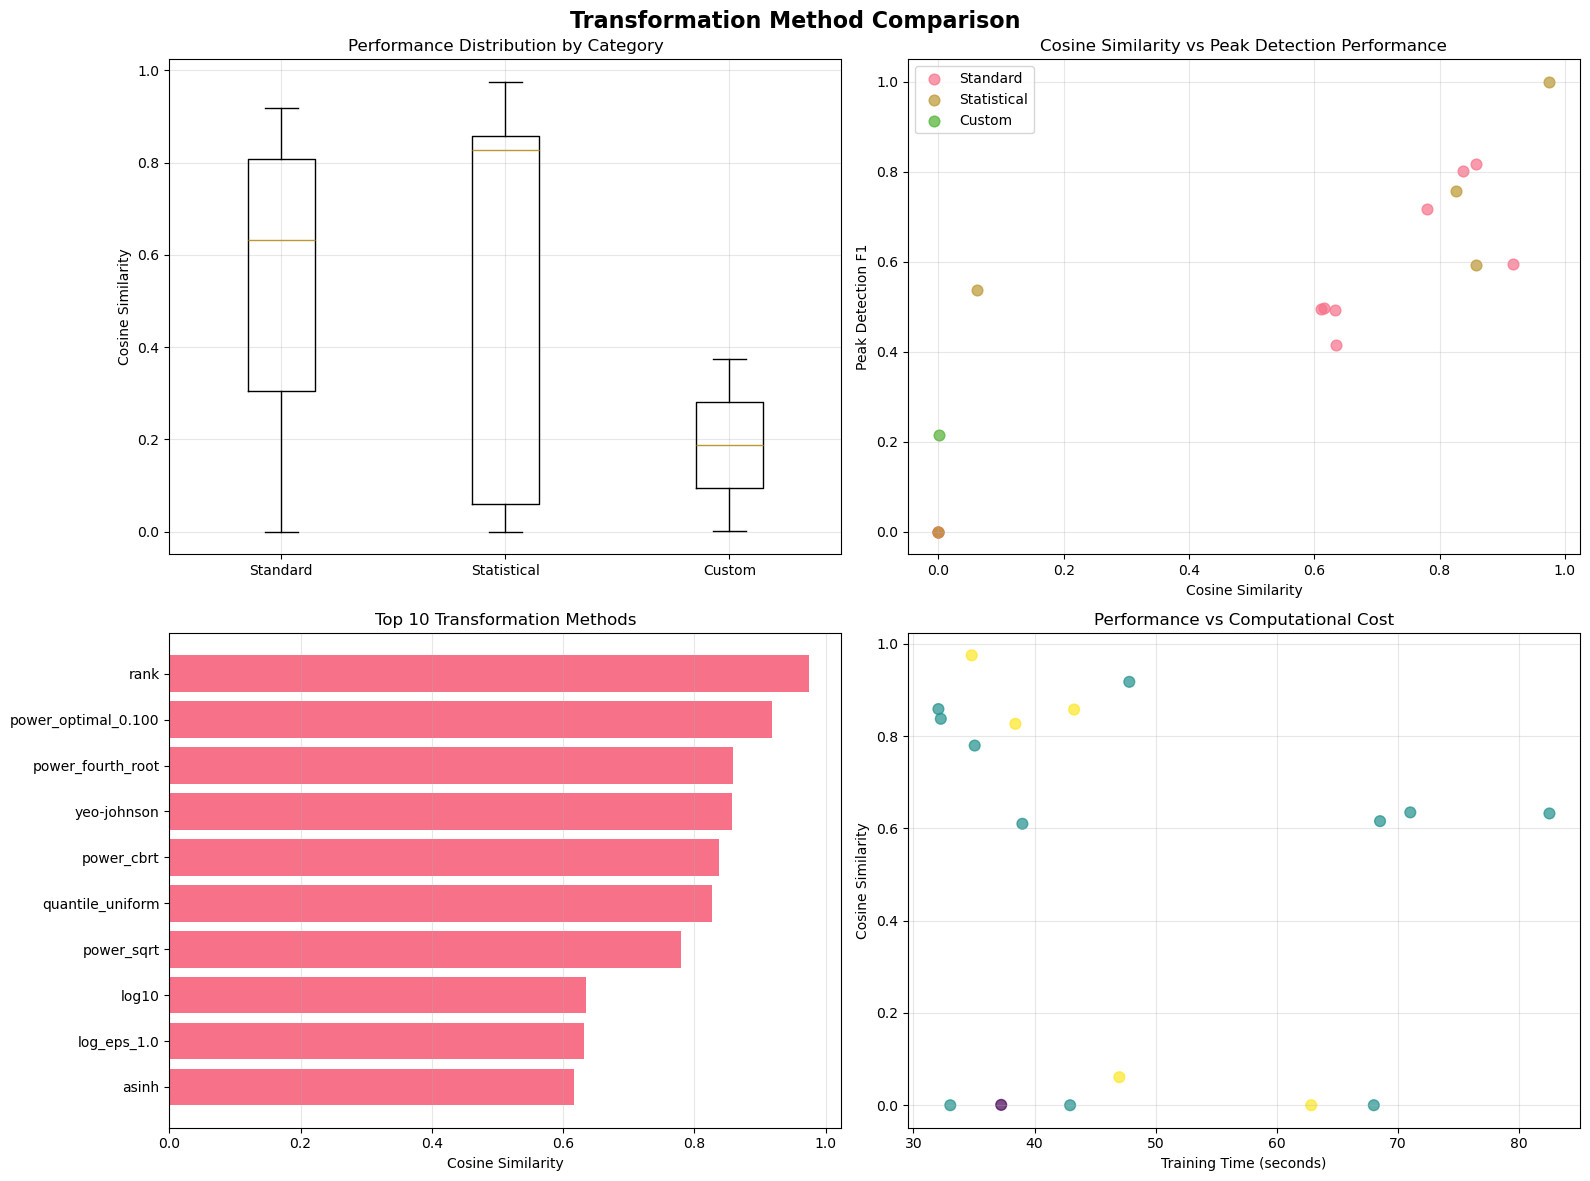


Intensity Range Analysis for Top 3 Methods:
------------------------------------------------------------

rank:
  0.100-0.500: MAE=0.052800, RelErr=0.1527, n=100627
  0.500-1.000: MAE=0.128004, RelErr=0.1543, n=35106

power_optimal_0.100:
  0.010-0.100: MAE=0.043662, RelErr=0.4366, n=100132
  0.500-1.000: MAE=0.150892, RelErr=0.2406, n=35590

power_fourth_root:
  0.001-0.010: MAE=0.026586, RelErr=8.4073, n=100132
  0.100-0.500: MAE=0.087372, RelErr=0.3081, n=30559
  0.500-1.000: MAE=0.219659, RelErr=0.3402, n=5031

Analysis complete


In [25]:
print("COMPREHENSIVE RESULTS ANALYSIS")
print("=" * 60)

# Collect all results
all_results = []
result_categories = {
    'Standard': standard_results,
    'Statistical': statistical_results,
    'Custom': custom_results
}

for category, results_dict in result_categories.items():
    for method_name, result in results_dict.items():
        if isinstance(result, dict) and 'cosine_similarity' in result:
            all_results.append({
                'method': method_name,
                'category': category,
                'cosine_similarity': result['cosine_similarity'],
                'mse': result.get('mse', np.nan),
                'peak_f1': result.get('peak_f1', np.nan),
                'training_time': result.get('training_time', np.nan)
            })

# Convert to DataFrame
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('cosine_similarity', ascending=False)

# 1. Top Methods Ranking
print("\nTop 10 Transformation Methods:")
print("-" * 60)
print(f"{'Rank':<6} {'Method':<30} {'Cosine Sim':<12} {'Peak F1':<10} {'Category':<12}")
print("-" * 60)

for idx, row in results_df.head(10).iterrows():
    print(f"{idx+1:<6} {row['method']:<30} {row['cosine_similarity']:<12.6f} "
          f"{row['peak_f1']:<10.4f} {row['category']:<12}")

# 2. Performance Improvement Analysis
baseline_cosine = results_df[results_df['method'] == 'none']['cosine_similarity'].values[0]
best_cosine = results_df.iloc[0]['cosine_similarity']
improvement = (best_cosine - baseline_cosine) / baseline_cosine * 100

print(f"\nPerformance Improvement:")
print(f"  Baseline (no transform): {baseline_cosine:.6f}")
print(f"  Best method ({results_df.iloc[0]['method']}): {best_cosine:.6f}")
print(f"  Improvement: {improvement:.2f}%")

# 3. Category Comparison Visualization (publication style)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Transformation Method Comparison', fontsize=16, fontweight='bold')

# Box plot by category
category_data = [results_df[results_df['category'] == cat]['cosine_similarity'].values 
                for cat in ['Standard', 'Statistical', 'Custom']]
axes[0, 0].boxplot(category_data, labels=['Standard', 'Statistical', 'Custom'])
axes[0, 0].set_ylabel('Cosine Similarity')
axes[0, 0].set_title('Performance Distribution by Category')
axes[0, 0].grid(True, alpha=0.3)

# Scatter plot: Cosine vs Peak F1
for category in ['Standard', 'Statistical', 'Custom']:
    cat_data = results_df[results_df['category'] == category]
    axes[0, 1].scatter(cat_data['cosine_similarity'], cat_data['peak_f1'], 
                      label=category, s=60, alpha=0.7)
axes[0, 1].set_xlabel('Cosine Similarity')
axes[0, 1].set_ylabel('Peak Detection F1')
axes[0, 1].set_title('Cosine Similarity vs Peak Detection Performance')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Bar chart of top methods
top_10 = results_df.head(10)
y_pos = np.arange(len(top_10))
bars = axes[1, 0].barh(y_pos, top_10['cosine_similarity'])
axes[1, 0].set_yticks(y_pos)
axes[1, 0].set_yticklabels(top_10['method'])
axes[1, 0].invert_yaxis()
axes[1, 0].set_xlabel('Cosine Similarity')
axes[1, 0].set_title('Top 10 Transformation Methods')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Training time comparison
time_data = results_df.dropna(subset=['training_time'])
axes[1, 1].scatter(time_data['training_time'], time_data['cosine_similarity'], 
                  c=time_data['category'].astype('category').cat.codes, s=60, alpha=0.7)
axes[1, 1].set_xlabel('Training Time (seconds)')
axes[1, 1].set_ylabel('Cosine Similarity')
axes[1, 1].set_title('Performance vs Computational Cost')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(MASTER_CONFIG['paths']['scaling_results_dir'], 'transformation_comparison.png'), dpi=300)
plt.show()

# 4. Intensity Range Analysis for Top Methods
print("\nIntensity Range Analysis for Top 3 Methods:")
print("-" * 60)

# Get predictions for top 3 methods
top_3_methods = results_df.head(3)['method'].values
intensity_bins = MASTER_CONFIG['analysis']['intensity_bins']

for method in top_3_methods:
    # Find the result
    for category_results in result_categories.values():
        if method in category_results and 'y_pred' in category_results[method]:
            result = category_results[method]
            range_metrics = analyze_intensity_ranges(
                result['y_test'].flatten(), 
                result['y_pred'].flatten(), 
                intensity_bins
            )
            
            print(f"\n{method}:")
            for range_name, metrics in range_metrics.items():
                print(f"  {range_name}: MAE={metrics['mae']:.6f}, "
                      f"RelErr={metrics['relative_error']:.4f}, "
                      f"n={metrics['n_points']}")
            break

print("\nAnalysis complete")

## 10. Transformation Effect Visualization

Visualize how different transformations affect the data distribution and predictions.

### Visualizations:
1. Distribution changes after transformation
2. Example spectrum predictions
3. Residual analysis
4. Q-Q plots for distribution assessment

TRANSFORMATION EFFECT VISUALIZATION


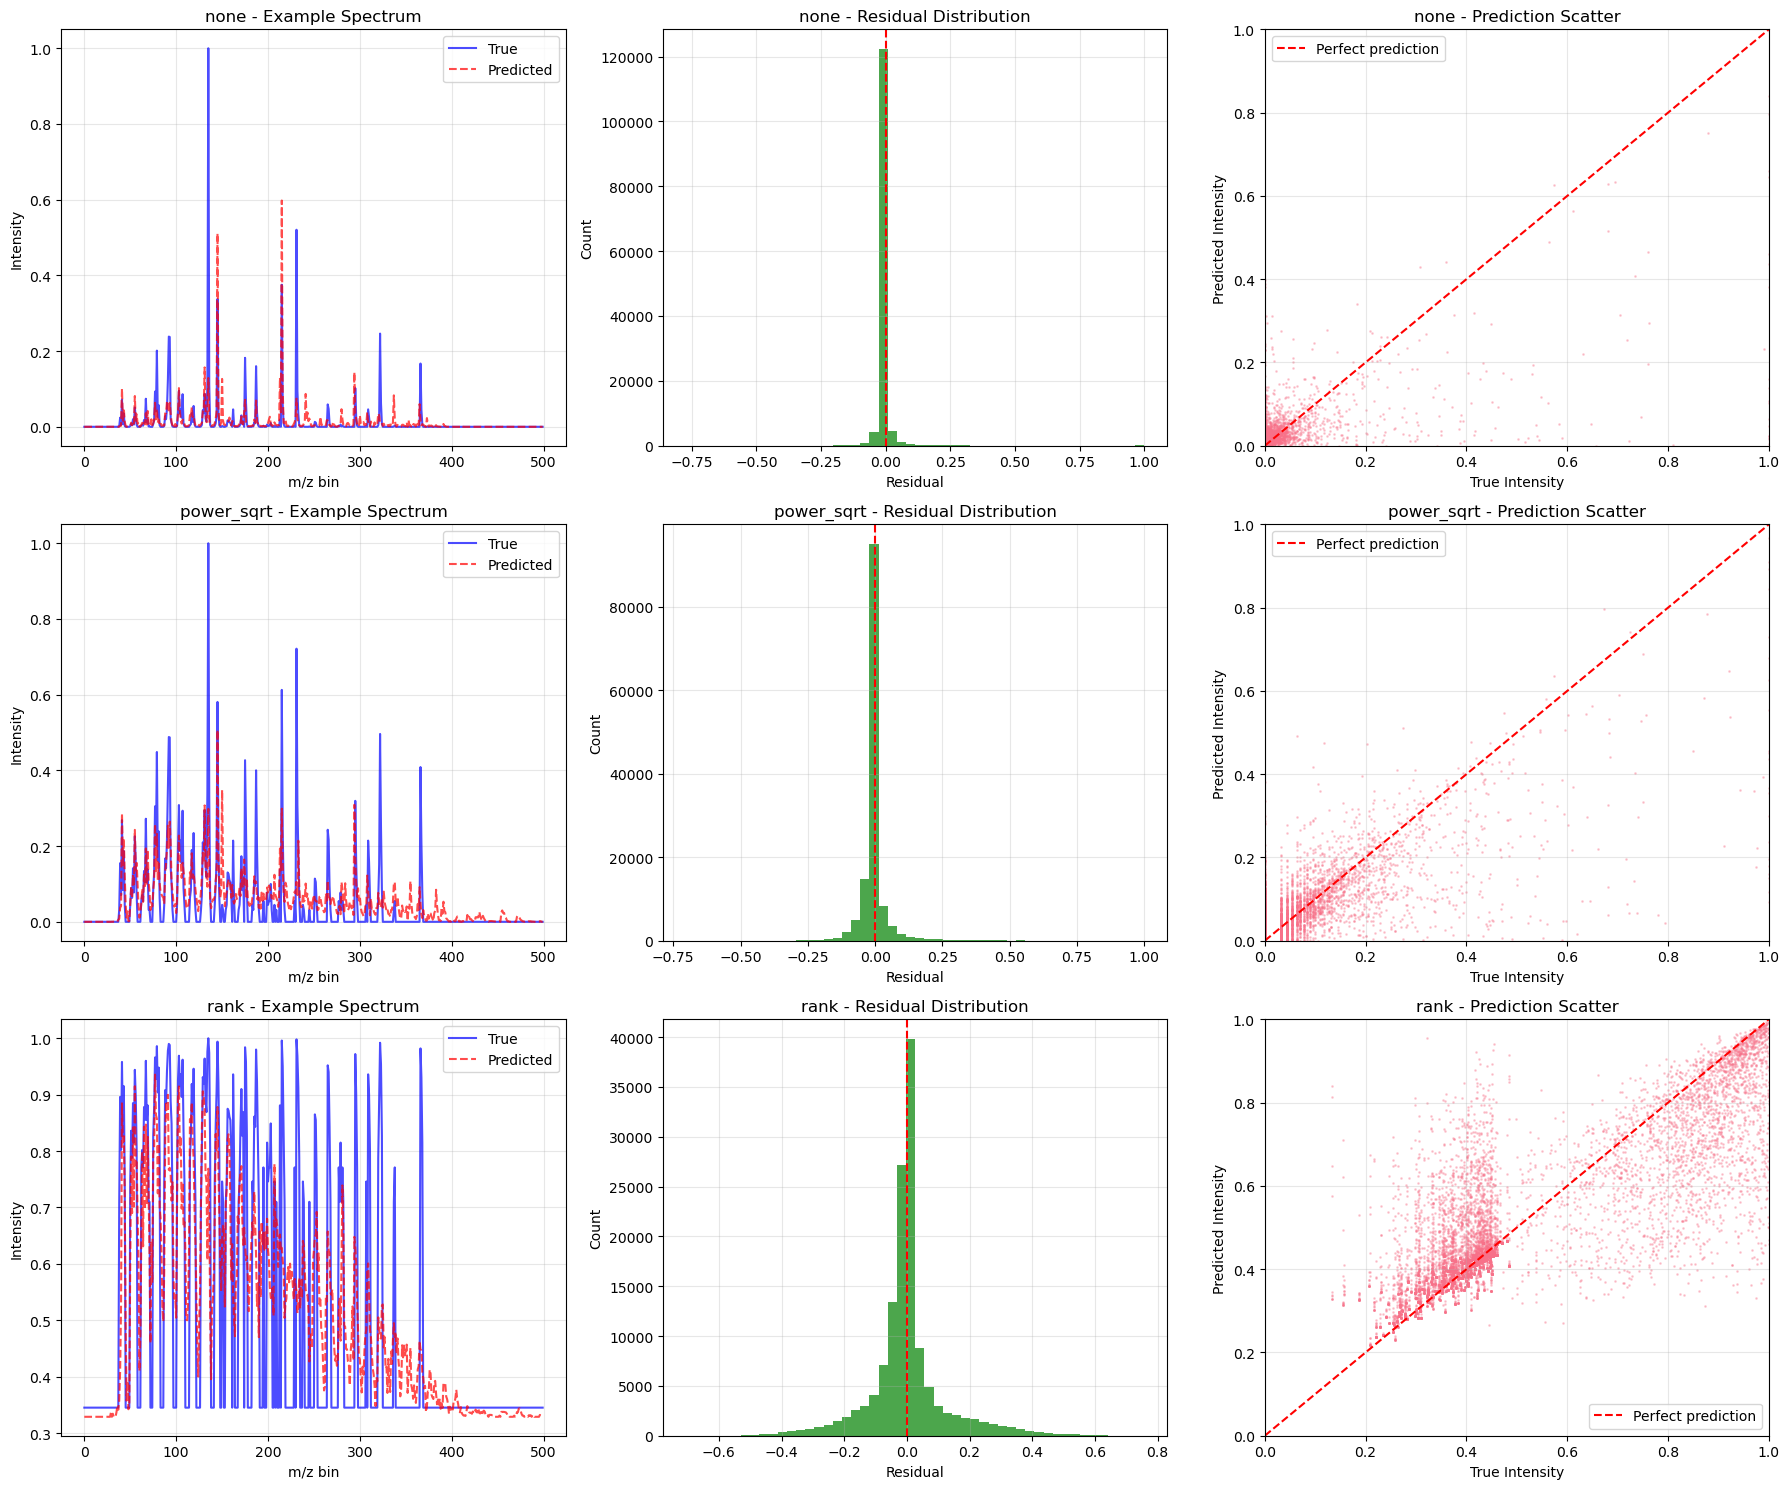


Visualization complete


In [26]:
print("TRANSFORMATION EFFECT VISUALIZATION")
print("=" * 60)

# Select methods to visualize
# Use consistent method keys present in results: 'none', 'power_sqrt', and best overall
best_method_key = results_df.iloc[0]['method']
viz_methods = ['none', 'power_sqrt', best_method_key]

# Create visualization (3x3)
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

for i, method in enumerate(viz_methods):
    # Find the result
    result = None
    for category_results in result_categories.values():
        if method in category_results:
            result = category_results[method]
            break
    
    if result is None or 'y_pred' not in result:
        # If missing, hide the row's axes
        for j in range(3):
            axes[i, j].axis('off')
        continue
    
    y_true = result['y_test']
    y_pred = result['y_pred']
    
    # 1. Example spectrum
    example_idx = min(42, y_true.shape[0]-1)  # Safe index
    axes[i, 0].plot(y_true[example_idx], 'b-', label='True', alpha=0.7)
    axes[i, 0].plot(y_pred[example_idx], 'r--', label='Predicted', alpha=0.7)
    axes[i, 0].set_xlabel('m/z bin')
    axes[i, 0].set_ylabel('Intensity')
    axes[i, 0].set_title(f'{method} - Example Spectrum')
    axes[i, 0].legend()
    axes[i, 0].grid(True, alpha=0.3)
    
    # 2. Residual distribution
    residuals = (y_true - y_pred).flatten()
    axes[i, 1].hist(residuals, bins=50, alpha=0.7, color='green')
    axes[i, 1].set_xlabel('Residual')
    axes[i, 1].set_ylabel('Count')
    axes[i, 1].set_title(f'{method} - Residual Distribution')
    axes[i, 1].axvline(0, color='red', linestyle='--')
    axes[i, 1].grid(True, alpha=0.3)
    
    # 3. True vs Predicted scatter
    sample_size = 10000
    indices = np.random.choice(y_true.size, min(sample_size, y_true.size), replace=False)
    y_true_sample = y_true.flatten()[indices]
    y_pred_sample = y_pred.flatten()[indices]
    
    axes[i, 2].scatter(y_true_sample, y_pred_sample, alpha=0.3, s=1)
    axes[i, 2].plot([0, 1], [0, 1], 'r--', label='Perfect prediction')
    axes[i, 2].set_xlabel('True Intensity')
    axes[i, 2].set_ylabel('Predicted Intensity')
    axes[i, 2].set_title(f'{method} - Prediction Scatter')
    axes[i, 2].set_xlim(0, 1)
    axes[i, 2].set_ylim(0, 1)
    axes[i, 2].legend()
    axes[i, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(MASTER_CONFIG['paths']['scaling_results_dir'], 'transformation_effects.png'), dpi=300)
plt.show()

print("\nVisualization complete")

## 11. Save Results and Recommendations

Save all results and provide final recommendations for target scaling in mass spectrometry prediction.

### Key Findings Summary:
- Best transformation method and parameters
- Performance improvements achieved
- Computational considerations
- Practical implementation guidelines

In [27]:
print("SAVING RESULTS AND FINAL RECOMMENDATIONS")
print("=" * 60)

# Save detailed results
results_path = os.path.join(MASTER_CONFIG['paths']['scaling_results_dir'], 'transformation_results.pkl')
with open(results_path, 'wb') as f:
    pickle.dump({
        'results_df': results_df,
        'all_results': all_results,
        'standard_results': standard_results,
        'statistical_results': statistical_results,
        'custom_results': custom_results,
        'optimal_power': optimal_alpha,
        'config': MASTER_CONFIG
    }, f)
print(f"Results saved to {results_path}")

# Save summary CSV
summary_path = os.path.join(MASTER_CONFIG['paths']['scaling_results_dir'], 'transformation_summary.csv')
results_df.to_csv(summary_path, index=False)
print(f"Summary CSV saved to {summary_path}")

# Generate recommendations
print("\n" + "=" * 60)
print("FINAL RECOMMENDATIONS")
print("=" * 60)

best_method = results_df.iloc[0]
print(f"\n1. OPTIMAL TRANSFORMATION:")
print(f"   Method: {best_method['method']}")
print(f"   Cosine Similarity: {best_method['cosine_similarity']:.6f}")
print(f"   Peak F1 Score: {best_method['peak_f1']:.4f}")
print(f"   Improvement over baseline: {improvement:.2f}%")

print(f"\n2. TOP 5 ALTERNATIVES:")
for idx, row in results_df.iloc[1:6].iterrows():
    print(f"   - {row['method']}: Cosine={row['cosine_similarity']:.6f}")

print(f"\n3. CATEGORY PERFORMANCE:")
category_means = results_df.groupby('category')['cosine_similarity'].agg(['mean', 'std', 'max'])
print(category_means)

print(f"\n4. PRACTICAL RECOMMENDATIONS:")
print(f"   - For highest accuracy: Use {best_method['method']}")
# Safely fetch sqrt result; it is stored under 'power_sqrt'
sqrt_row = results_df[results_df['method'].isin(['power_sqrt','sqrt'])].head(1)
if not sqrt_row.empty:
    sqrt_cos = sqrt_row['cosine_similarity'].values[0]
    sqrt_name = sqrt_row['method'].values[0]
    print(f"   - For simplicity: Use {sqrt_name} transformation (Cosine={sqrt_cos:.6f})")
else:
    print(f"   - For simplicity: Use square-root-like power transform (α=0.5)")
print(f"   - For interpretability: Use power transformation with α={optimal_alpha:.3f}")

if 'adaptive' in best_method['method']:
    print(f"\n5. ADAPTIVE TRANSFORMATION PARAMETERS:")
    print(f"   - Low intensity threshold: {best_adaptive_config['low_threshold']}")
    print(f"   - High intensity threshold: {best_adaptive_config['high_threshold']}")
    print(f"   - Mid-range power: {best_adaptive_config['mid_power']}")

print(f"\n6. IMPLEMENTATION NOTES:")
print(f"   - Always ensure non-negative values after inverse transformation")
print(f"   - Consider computational cost for real-time applications")
print(f"   - Validate on independent test sets before deployment")
print(f"   - Monitor performance across different compound classes")

print("\n" + "=" * 60)
print("TARGET SCALING ANALYSIS COMPLETE")
print("=" * 60)

SAVING RESULTS AND FINAL RECOMMENDATIONS
Results saved to ../data/results/target_scaling/transformation_results.pkl
Summary CSV saved to ../data/results/target_scaling/transformation_summary.csv

FINAL RECOMMENDATIONS

1. OPTIMAL TRANSFORMATION:
   Method: rank
   Cosine Similarity: 0.975266
   Peak F1 Score: 1.0000
   Improvement over baseline: 59.84%

2. TOP 5 ALTERNATIVES:
   - power_optimal_0.100: Cosine=0.917806
   - power_fourth_root: Cosine=0.858771
   - yeo-johnson: Cosine=0.857763
   - power_cbrt: Cosine=0.837685
   - quantile_uniform: Cosine=0.826777

3. CATEGORY PERFORMANCE:
                 mean       std       max
category                                 
Custom       0.187734  0.264408  0.374698
Standard     0.535202  0.359601  0.917806
Statistical  0.544124  0.472707  0.975266

4. PRACTICAL RECOMMENDATIONS:
   - For highest accuracy: Use rank
   - For simplicity: Use power_sqrt transformation (Cosine=0.779677)
   - For interpretability: Use power transformation with α=0.